In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import numpy as np
from torchvision import transforms
# from diffusers import StableCascadeDecoderPipeline, StableCascadePriorPipeline
from PIL import Image
from reconstructor import Reconstructor
from utils import show_images
import torchvision

/export/raid1/home/kneel027/mamba/envs/mindeye_imagery_sc/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
recon = Reconstructor(compile_models=False)
recon_path = "/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/output/mental_imagery_paper_b3/vision/subj01_40sess_hypatia_ridge_sc3/subject1/"
image_preds = torch.load(recon_path + "stable_cascade_image_voxels.pt")
text_preds = torch.load(recon_path + "stable_cascade_text_voxels.pt")
latent_preds = torch.load(recon_path + "stable_cascade_latent_voxels.pt")

Stable Cascade Reconstructor: Loading model...
['model_version', 'effnet_checkpoint_path', 'previewer_checkpoint_path']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


/export/raid1/home/kneel027/mamba/envs/mindeye_imagery_sc/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'previewer']
STAGE C READY
['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
STAGE B READY


/tmp/ipykernel_1022372/398544099.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_preds = torch.load(recon_path + "stable_cascade_image_voxels.pt")
/tmp/ipykernel_1

tensor(0.0216, dtype=torch.float64) tensor(0.1164, dtype=torch.float64) tensor(16.5613, dtype=torch.float64) tensor(11473.8568, dtype=torch.float64)
torch.Size([77, 1280]) torch.Size([1, 768]) torch.Size([9216])


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


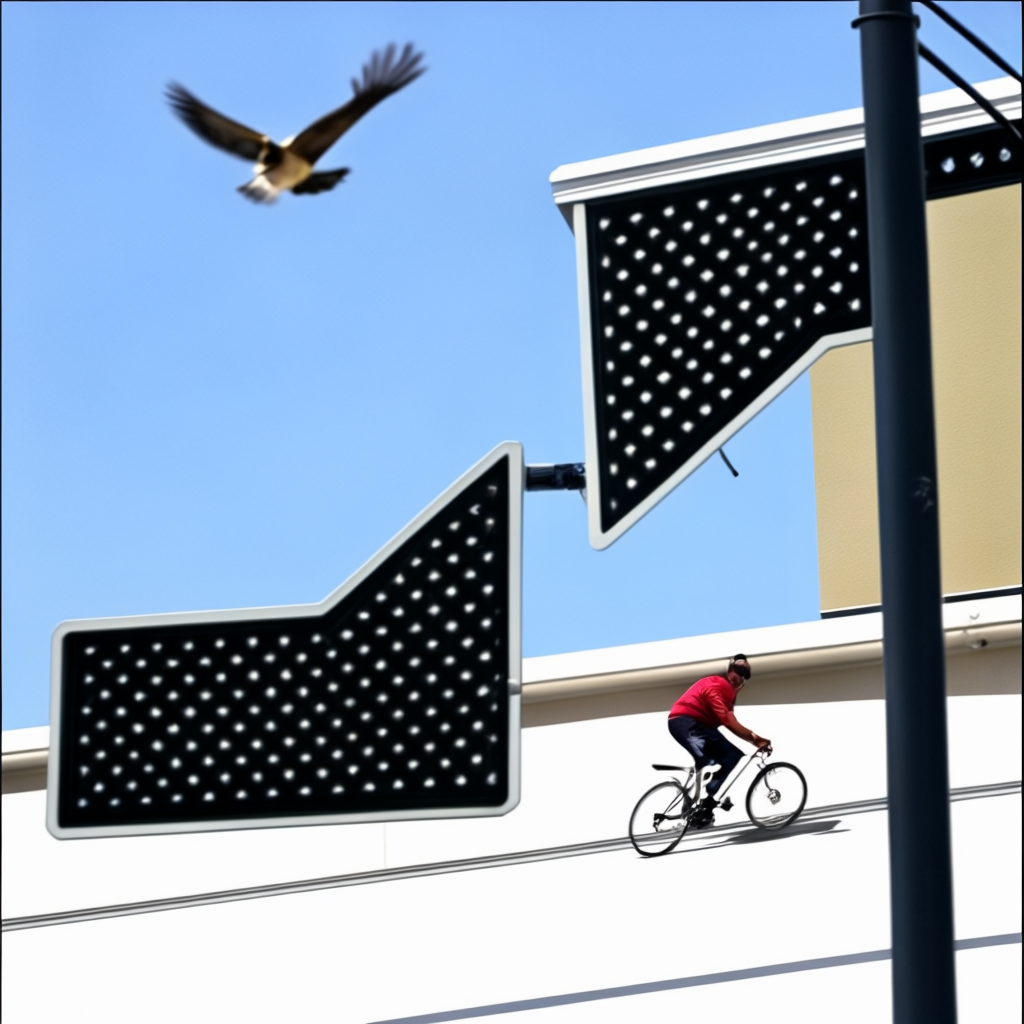

In [16]:
index = 1
latent_embed = latent_preds[index]
image_embed = image_preds[index]
prompt_embed = text_preds[index]
# prompt = "a woman riding a horse"
# image = Image.open("/home/naxos2-raid25/kneel027/home/kneel027/IP-Adapter_MEI/assets/images/woman.png")
# prompt_embed = recon.embed_text(prompt)
# image_embed = recon.embed_image(image)
# image = Image.open("/home/naxos2-raid25/kneel027/home/kneel027/IP-Adapter_MEI/assets/images/horse.jpg")
# latent_embed = recon.embed_latent(image)
print(torch.mean(image_embed), torch.mean(prompt_embed), torch.sum(image_embed), torch.sum(prompt_embed))
print(prompt_embed.shape, image_embed.shape, latent_embed.shape)
sample = recon.reconstruct(latent=latent_embed, 
                           c_i=image_embed, 
                           c_t=prompt_embed, 
                           n_samples=4,
                           textstrength=0.5,
                           strength=0.75,
                           cfg_b=1.1)
# show_images(sample)
pil = transforms.ToPILImage()(sample.clamp(0, 1)[0])
pil

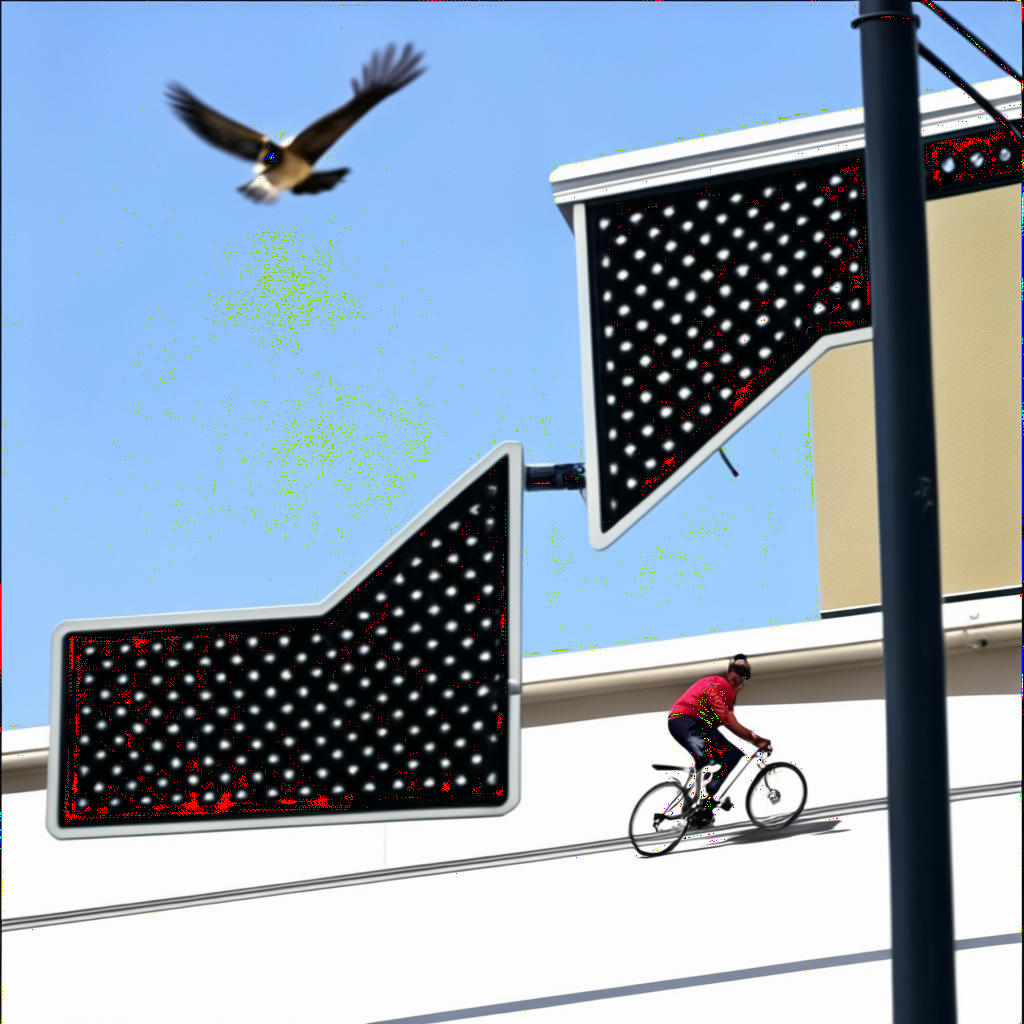

In [17]:
pil = transforms.ToPILImage()(sample[0])
pil